# 7.1 MLP on Adult Income data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier

from Dataset import Dataset
from utils import get_splits

# Model training

In [2]:
df1 = pd.read_csv('data/adult.data', header=None)
df2 = pd.read_csv('data/adult.test', header=None)
df = pd.concat([df1, df2])

In [3]:
df.columns = ['Age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
             'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
             'hours-per-week', 'native-country', 'over-50k']

In [4]:
df['over-50k'] = df['over-50k'].apply(lambda x: x.replace('.',''))

In [5]:
df = df.drop(['native-country'], axis=1)

In [6]:
df = pd.get_dummies(df, drop_first=True)

In [7]:
df.rename(columns={"over-50k_ >50K": "over_50k"}, inplace=True)

In [8]:
train = df[:len(df1)]
test = df[len(df1):]

In [9]:
X_train, y_train = train.drop('over_50k', axis=1), train['over_50k']
X_test, y_test = test.drop('over_50k', axis=1), test['over_50k']

In [10]:
mlp = MLPClassifier(hidden_layer_sizes=(100,75), random_state=0)

In [11]:
mlp.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(100, 75), random_state=0)

In [12]:
mlp.score(X_test, y_test)

0.789017873594988

In [13]:
probs = mlp.predict_proba(X_test)

In [14]:
df_test = pd.DataFrame(X_test)
df_test['actual'] = y_test

In [15]:
df_test[['prob_0','prob_1']] = probs

In [16]:
df_test['pred'] = df_test['prob_1'].apply(lambda x: 0 if x<0.5 else 1)

# Calibration analysis

In [17]:
df = pd.read_csv('data/adult_out.csv', index_col=0)
df = Dataset(df, cal_size=2500)
var='Age'

## Uncalibrated

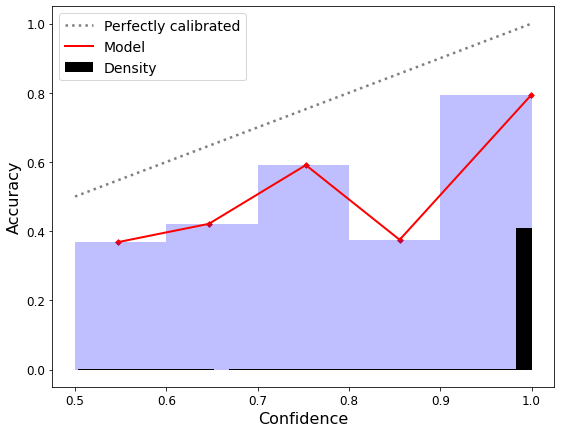

In [18]:
df.reliability_diagram(hist_weight=0.00003)

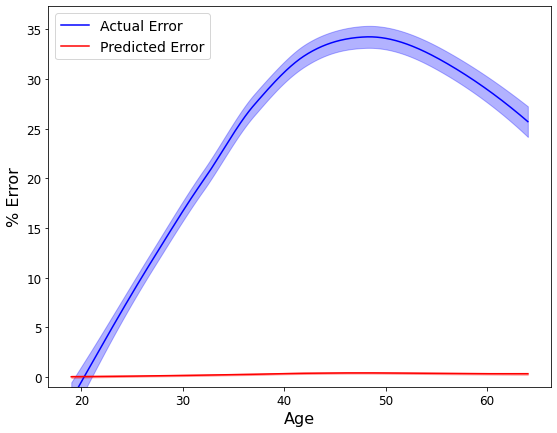

In [19]:
y_lim = df.gen_plot_lowess(var=var,s=0.9)

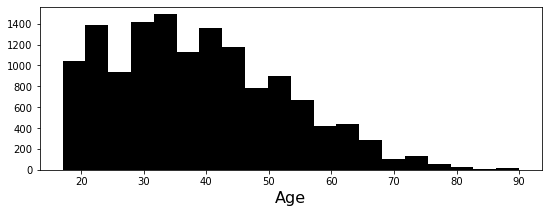

In [20]:
f, ax1 = plt.subplots(1, 1, figsize=(9,3))
ax1.hist(df.df[var], bins=20, color='black')
ax1.set_xlabel("Age", fontsize=16)
plt.show()

## Beta-calibrated

In [21]:
for col in ['age', 'fnlwgt', 'education-num','hours-per-week']:
    print(col)
    print(df.compute_VECE(col, label="_beta"))
    print(df.max_diff(col, s=0.9, label="_beta"))

age
0.09593200720465152
23.437438334735443
fnlwgt
0.050584139756493444
12.080859520823783
education-num
0.09952789922726031
20.127375819967014
hours-per-week
0.07935016463436362
18.205069555557007


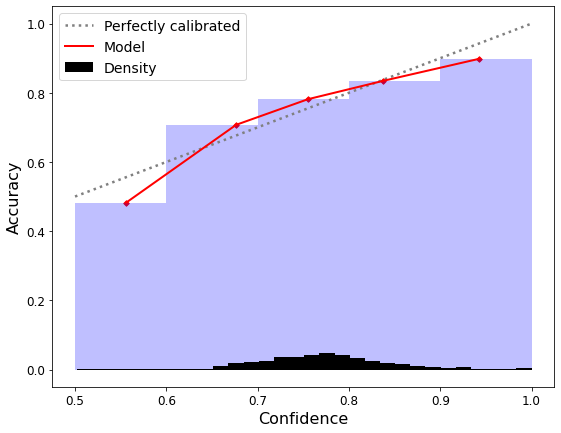

In [22]:
df.reliability_diagram(hist_weight=0.00003, label="_beta")

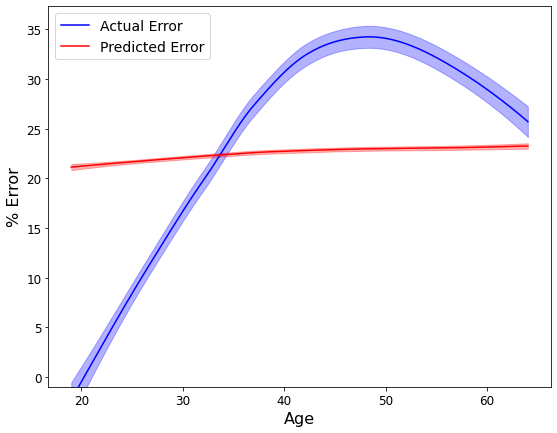

In [23]:
df.gen_plot_lowess(var=var, label="_beta", use_lim=True, ylim=y_lim, s=0.9)

## Variable-wise calibrated

In [24]:
splits = get_splits(df.df_cal[[var]], df.df[[var]], df.df_cal['actual'], df.df['actual'],
                  max_depth=3, min_samples_leaf=int(len(df.df_cal)/10))

In [25]:
df.split_calibrate(var, splits, how='beta')

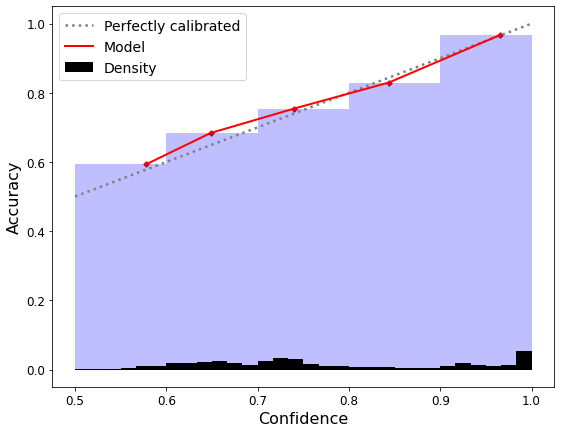

In [26]:
df.reliability_diagram(hist_weight=0.00003, label="_split")

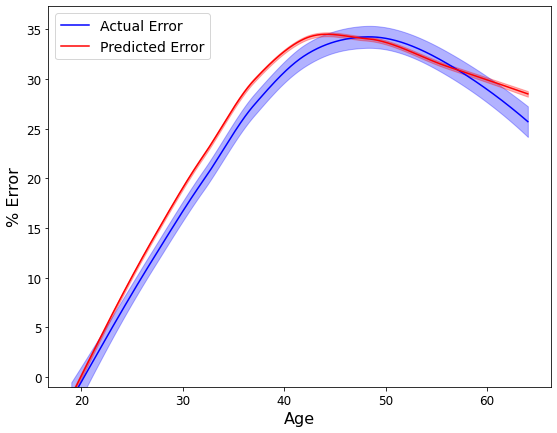

In [27]:
df.gen_plot_lowess(var=var, label="_split", use_lim=True, ylim=y_lim, s=0.9)

## Overall results

In [28]:
bins=10

In [29]:
print("uncalibrated ECE=",df.compute_ECE(num_bins=bins))
print("Kumar calibrated ECE=",df.compute_ECE(label="_kumar", num_bins=bins))
print("Logistic calibrated ECE=", df.compute_ECE(label="_log", num_bins=bins))
print("Beta calibrated ECE=", df.compute_ECE(label="_beta", num_bins=bins))
print("Variable-wise calibrated ECE=",df.compute_ECE(label="_split", num_bins=bins))

uncalibrated ECE= 0.20665741864533652
Kumar calibrated ECE= 0.02268951896628304
Logistic calibrated ECE= 0.045727664518174393
Beta calibrated ECE= 0.01646054558348676
Variable-wise calibrated ECE= 0.01643069123546091


In [30]:
print("uncalibrated VECE =",df.compute_VECE(var=var, num_bins=bins))
print("Kumar calibrated VECE =",df.compute_VECE(label="_kumar",var=var, num_bins=bins))
print("Logistic calibrated VECE =",df.compute_VECE(label="_log",var=var, num_bins=bins))
print("Beta calibrated VECE =",df.compute_VECE(label="_beta",var=var, num_bins=bins))
print("Variable-wise calibrated VECE =",df.compute_VECE(label="_split",var=var, num_bins=bins))

uncalibrated VECE = 0.20665741864533657
Kumar calibrated VECE = 0.09247530358355228
Logistic calibrated VECE = 0.1012856867529069
Beta calibrated VECE = 0.09593200720465153
Variable-wise calibrated VECE = 0.021069835256998477
